# Pendulum Predictions

3 models are compared:

- Base: Multi-Layer Perceptron
- HNN0: Hamliltonian Neural Network
- HNN1: Hamliltonian Neural Network with Physics-Informed Penalty

Pendulum configs can be found at: https://github.com/uriyeobi/PIML/tree/main/config


In [1]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import pandas as pd
from typing import List
import os

parent_dir = Path(os.getcwd()).parent

sys.path.append(str(parent_dir / "src" / "pendulum"))
sys.path.append(str(parent_dir / "src" / "nn"))

from base_mlp import train_base_mlp, integrate_base_mlp
from hnn import train_hnn, integrate_hnn
from spec import TrainSpec
from utils import generate_data

from hnn import (
    calculate_single_pendulum_hamiltonian,
    calculate_double_pendulum_hamiltonian,
)


2023-06-21 17:18:19.002391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
X_single: List[str] = ["q", "p"]
y_single: List[str] = ["dqdt", "dpdt"]
X_double: List[str] = ["q1", "q2", "p1", "p2"]
y_double: List[str] = ["dq1dt", "dq2dt", "dp1dt", "dp2dt"]

rtol: float = 1e-6


In [3]:
def get_params(df: pd.DataFrame, X_vars: List[str]):
    """Get parameters."""
    N_train = int(df.shape[0] * 0.8)
    t_eval = df["time_step"].loc[N_train:].values
    t_span = [t_eval[0], t_eval[-1]]
    y0 = df.iloc[N_train][X_vars].values
    return [N_train, t_eval, t_span, y0, X_vars]


## Data Generation


In [4]:
## Data Generation
[df, mlg] = generate_data(config_dir=parent_dir / "config")


In [5]:
df.shape


(2001, 31)

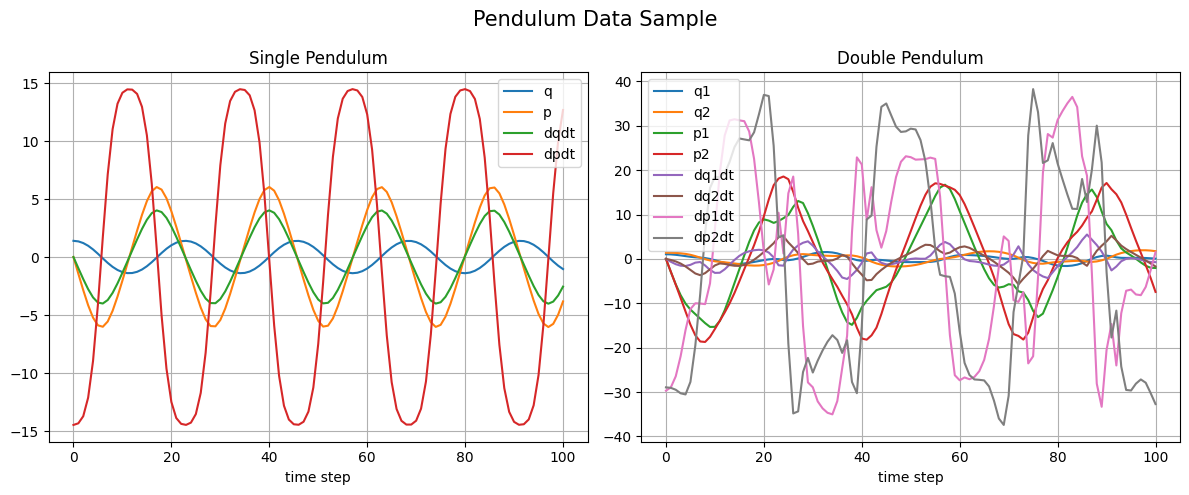

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
map_generalized_coord_momenta = {
    "Single Pendulum": X_single + y_single,
    "Double Pendulum": X_double + y_double,
}
for i, (k, v) in enumerate(map_generalized_coord_momenta.items()):
    ax = axes[i]
    df[v].loc[:100].plot(ax=ax)
    ax.grid()
    ax.set_title(k)
    ax.set_xlabel("time step")
fig.suptitle("Pendulum Data Sample", size=15)
fig.tight_layout()
fig.savefig("fig/pendulum_data_sample2.png", dpi=200, facecolor="white")


# Single Pendulum


### Train


In [7]:
pendulum = "single"
X_vars = X_single
y_vars = y_single

# training data
[N_train, t_eval, t_span, y0, X_vars] = get_params(df=df, X_vars=X_vars)
X_train = df[X_vars][:N_train].to_numpy()
y_train = df[y_vars][:N_train].to_numpy()


In [8]:
N_train


1600

In [9]:
train_spec0 = TrainSpec(
    mlg=mlg[pendulum],
    learning_rate=0.002,
    hidden_dims=[200, 200],
    epochs=1000,
    hamiltonian_method="curr",
    penalty_lamb=0,
)
train_spec1 = TrainSpec(
    mlg=mlg[pendulum],
    learning_rate=0.002,
    hidden_dims=[200, 200],
    epochs=1000,
    hamiltonian_method="next",
    penalty_lamb=0.1,
)


In [10]:
hnn1 = train_hnn(X_train, y_train, train_spec1)
hnn0 = train_hnn(X_train, y_train, train_spec0)
base = train_base_mlp(X_train, y_train, train_spec0)


ham0=-2.5526282117038774
itr=100, loss=0.08463142900759614
itr=200, loss=0.0002939369681922082
itr=300, loss=0.00010022674949389312
itr=400, loss=5.4771485504212565e-05
itr=500, loss=3.545207337786143e-05
itr=600, loss=2.4981897942355193e-05
itr=700, loss=1.8656724562117853e-05
itr=800, loss=1.4499329526436148e-05
itr=900, loss=1.1521305012269694e-05
itr=1000, loss=9.248565854949276e-06
ham0=-2.5526282117038774
itr=100, loss=0.02606279563618854
itr=200, loss=0.00036951077702222107
itr=300, loss=5.717031201179306e-05
itr=400, loss=2.3292908580829778e-05
itr=500, loss=1.1670387841188434e-05
itr=600, loss=6.1203680503248115e-06
itr=700, loss=3.5342720598262e-06
itr=800, loss=0.004298446263482795
itr=900, loss=1.9366947123884378e-06
itr=1000, loss=6.280722828718314e-06


In [11]:
hnn0_pred = integrate_hnn(model=hnn0, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)
hnn1_pred = integrate_hnn(model=hnn1, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)
base_pred = integrate_base_mlp(base, t_span, y0, t_eval=t_eval, rtol=rtol)


### Plot


In [12]:
col_energy_total = f"energy_total_{pendulum}"
df_base = (
    pd.DataFrame(base_pred["y"].T, columns=X_vars, index=df.loc[N_train:].index)
    .assign(case="base_pred")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_single_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)
df_hnn0 = (
    pd.DataFrame(hnn0_pred["y"].T, columns=X_vars, index=df.loc[N_train:].index)
    .assign(case="hnn0_pred")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_single_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)
df_hnn1 = (
    pd.DataFrame(hnn1_pred["y"].T, columns=X_vars, index=df.loc[N_train:].index)
    .assign(case="hnn1_pred")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_single_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)

df_act = (
    df[X_vars]
    .loc[N_train:]
    .assign(case="actual")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_single_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)
df_all = pd.concat(
    [
        df_act,
        df_base,
        df_hnn0,
        df_hnn1,
    ],
    axis=0,
)


In [13]:
# Error in (q, p)
df_err_qp = pd.concat(
    [
        (df_base[X_vars] - df_act[X_vars]).abs().assign(case="base_pred - actual"),
        (df_hnn0[X_vars] - df_act[X_vars]).abs().assign(case="hnn0_pred - actual"),
        (df_hnn1[X_vars] - df_act[X_vars]).abs().assign(case="hnn1_pred - actual"),
    ],
    axis=0,
)

# Error in total energy
df_err_energy = pd.concat(
    [
        (df_base[[col_energy_total]] / df_act[[col_energy_total]] - 1)
        .abs()
        .assign(case="base_pred / actual - 1"),
        (df_hnn0[[col_energy_total]] / df_act[[col_energy_total]] - 1)
        .abs()
        .assign(case="hnn0_pred / actual - 1"),
        (df_hnn1[[col_energy_total]] / df_act[[col_energy_total]] - 1)
        .abs()
        .assign(case="hnn1_pred / actual - 1"),
    ],
    axis=0,
)


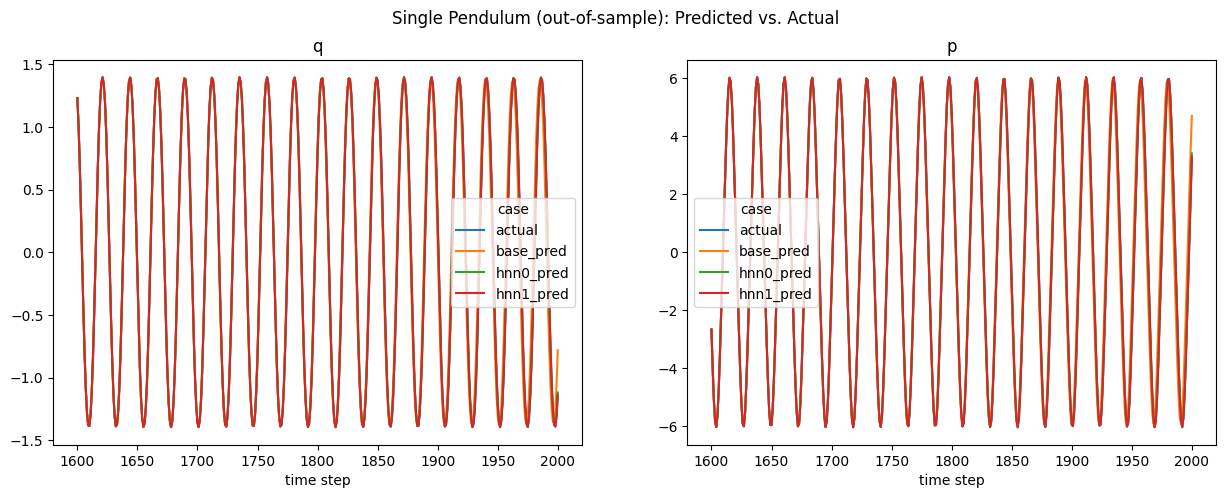

In [14]:
fig, axes = plt.subplots(int(len(X_vars) / 2), 2, figsize=(12, 2.0 * len(X_vars)))
for i, ax in enumerate(
    axes.reshape(
        len(X_vars),
    )
):
    val = X_vars[i]
    df_plot = df_all[X_vars + ["case"]].pivot_table(
        index=df_all.index, values=val, columns="case"
    )
    df_plot.plot(ax=ax)
    ax.set_title(val)
    ax.set_xlabel("time step")
fig.suptitle("Single Pendulum (out-of-sample): Predicted vs. Actual")
fig.savefig("fig/hnn_single_pendulum_pred_act.png", dpi=200, facecolor="white")


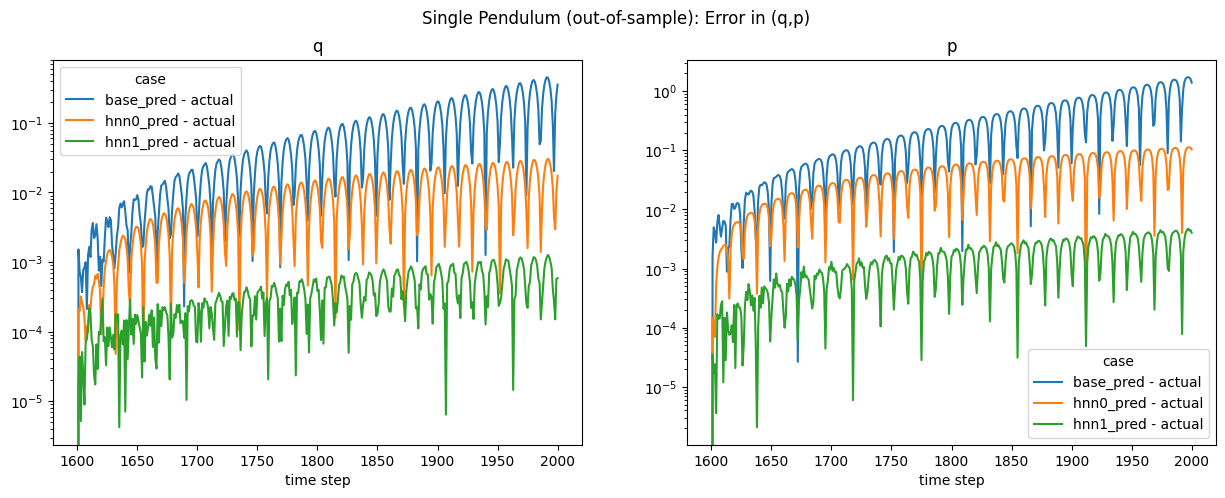

In [15]:
fig, axes = plt.subplots(int(len(X_vars) / 2), 2, figsize=(12, 2.0 * len(X_vars)))
for i, ax in enumerate(
    axes.reshape(
        len(X_vars),
    )
):
    val = X_vars[i]
    df_plot = df_err_qp[X_vars + ["case"]].pivot_table(
        index=df_err_qp.index, values=val, columns="case"
    )
    df_plot.plot(ax=ax)
    ax.set_title(val)
    ax.set_xlabel("time step")
    ax.set_yscale("log")
fig.suptitle("Single Pendulum (out-of-sample): Error in (q,p)")
fig.savefig("fig/hnn_single_pendulum_error_qp.png", dpi=200, facecolor="white")


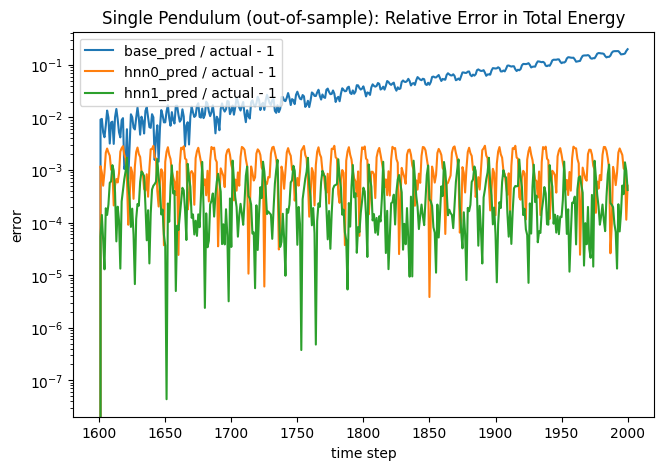

In [16]:
fig, ax = plt.subplots(figsize=(7.5, 2.5 * 2))
val = col_energy_total
df_plot = df_err_energy[[col_energy_total, "case"]].pivot_table(
    index=df_err_energy.index, values=val, columns="case"
)
df_plot.plot(ax=ax)
ax.set_title(val)
ax.set_xlabel("time step")
ax.set_ylabel("error")
ax.set_yscale("log")
ax.legend(loc="upper left")
ax.set_title("Single Pendulum (out-of-sample): Relative Error in Total Energy")
fig.savefig("fig/hnn_single_pendulum_error_energy.png", dpi=200, facecolor="white")


# Double Pendlum


### Train


In [52]:
pendulum = "double"
X_vars = X_double
y_vars = y_double

# training data
[N_train, t_eval, t_span, y0, X_vars] = get_params(df=df, X_vars=X_vars)
X_train = df[X_vars][:N_train].to_numpy()
y_train = df[y_vars][:N_train].to_numpy()


In [53]:
train_spec0 = TrainSpec(
    mlg=mlg[pendulum],
    learning_rate=0.00025,
    hidden_dims=[400, 400, 400, 400],
    epochs=2000,
    hamiltonian_method="curr",
    penalty_lamb=0,
)
train_spec1 = TrainSpec(
    mlg=mlg[pendulum],
    learning_rate=0.00025,
    hidden_dims=[400, 400, 400, 400],
    epochs=2000,
    hamiltonian_method="next",
    penalty_lamb=0.1,
)


In [54]:
base = train_base_mlp(X_train, y_train, train_spec0)
hnn1 = train_hnn(X_train, y_train, train_spec1)
hnn0 = train_hnn(X_train, y_train, train_spec0)


ham0=-22.25525642340776
itr=100, loss=158.52244831303088
itr=200, loss=47.48463203361037
itr=300, loss=26.767615390661472
itr=400, loss=2.3222883754704013
itr=500, loss=0.306387594585953
itr=600, loss=0.11536637375732607
itr=700, loss=0.06468183097875324
itr=800, loss=0.042874774274170746
itr=900, loss=0.031079867044087772
itr=1000, loss=0.037279485830932026
itr=1100, loss=0.019070013608217303
itr=1200, loss=0.1601422307581964
itr=1300, loss=0.013212902269992114
itr=1400, loss=0.011239280068242447
itr=1500, loss=0.011755286763116723
itr=1600, loss=0.008565871373710692
itr=1700, loss=0.009634199852855563
itr=1800, loss=0.006745749104770788
itr=1900, loss=0.007397408593872343
itr=2000, loss=0.007397748636790064
ham0=-22.25525642340776
itr=100, loss=49.83020240025686
itr=200, loss=13.529731496452593
itr=300, loss=9.654873541714688
itr=400, loss=5.151659096284319
itr=500, loss=1.577859176813946
itr=600, loss=0.7940222815953994
itr=700, loss=0.49531904825200035
itr=800, loss=0.3373763297050

In [55]:
base_pred = integrate_base_mlp(base, t_span, y0, t_eval=t_eval, rtol=rtol)
hnn0_pred = integrate_hnn(model=hnn0, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)
hnn1_pred = integrate_hnn(model=hnn1, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)


### Plot


In [56]:
col_energy_total = f"energy_total_{pendulum}"
df_base = (
    pd.DataFrame(base_pred["y"].T, columns=X_vars, index=df.loc[N_train:].index)
    .assign(case="base_pred")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_double_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)
df_hnn0 = (
    pd.DataFrame(hnn0_pred["y"].T, columns=X_vars, index=df.loc[N_train:].index)
    .assign(case="hnn0_pred")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_double_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)
df_hnn1 = (
    pd.DataFrame(hnn1_pred["y"].T, columns=X_vars, index=df.loc[N_train:].index)
    .assign(case="hnn1_pred")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_double_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)

df_act = (
    df[X_vars]
    .loc[N_train:]
    .assign(case="actual")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_double_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)
df_all = pd.concat(
    [
        df_act,
        df_base,
        df_hnn0,
        df_hnn1,
    ],
    axis=0,
)


In [57]:
# Error in (q, p)
df_err_qp = pd.concat(
    [
        (df_base[X_vars] - df_act[X_vars]).abs().assign(case="base_pred - actual"),
        (df_hnn0[X_vars] - df_act[X_vars]).abs().assign(case="hnn0_pred - actual"),
        (df_hnn1[X_vars] - df_act[X_vars]).abs().assign(case="hnn1_pred - actual"),
    ],
    axis=0,
)

# Error in total energy
df_err_energy = pd.concat(
    [
        (df_base[[col_energy_total]] / df_act[[col_energy_total]] - 1)
        .abs()
        .assign(case="base_pred / actual - 1"),
        (df_hnn0[[col_energy_total]] / df_act[[col_energy_total]] - 1)
        .abs()
        .assign(case="hnn0_pred / actual - 1"),
        (df_hnn1[[col_energy_total]] / df_act[[col_energy_total]] - 1)
        .abs()
        .assign(case="hnn1_pred / actual - 1"),
    ],
    axis=0,
)


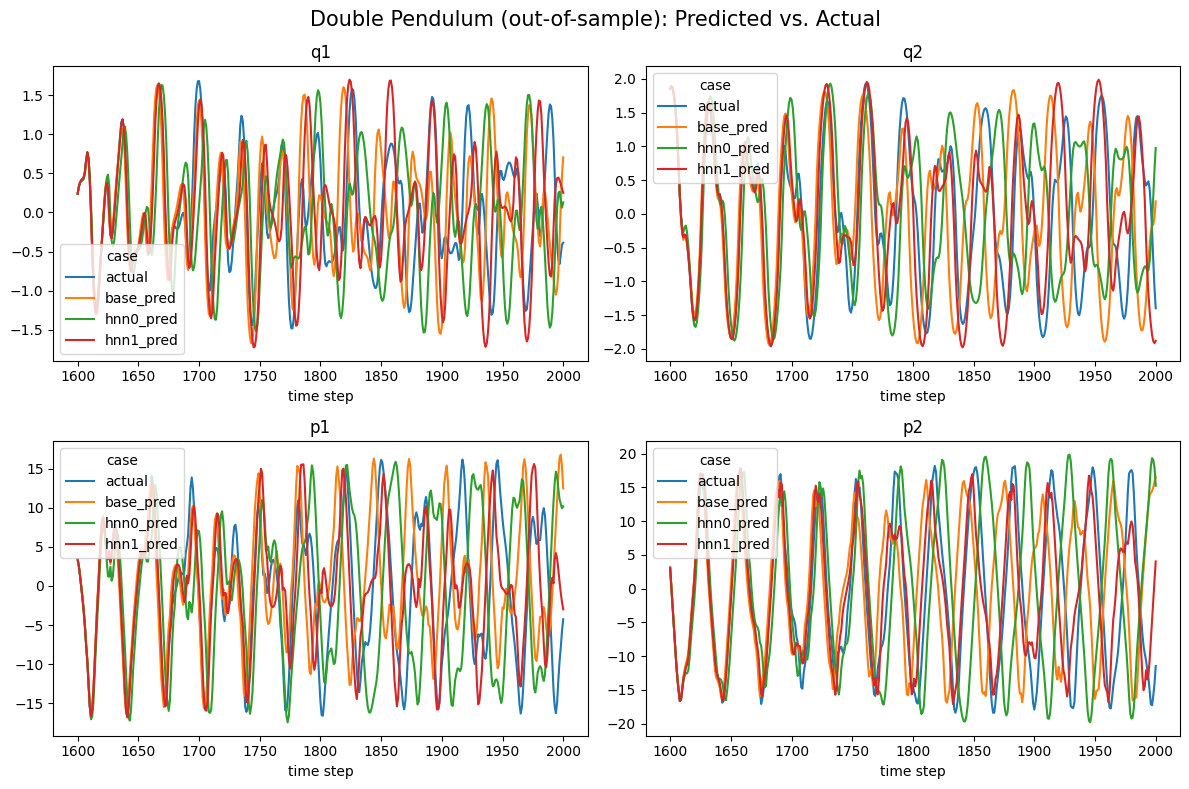

In [67]:
fig, axes = plt.subplots(int(len(X_vars) / 2), 2, figsize=(12, 2.0 * len(X_vars)))
for i, ax in enumerate(
    axes.reshape(
        len(X_vars),
    )
):
    val = X_vars[i]
    df_plot = df_all[X_vars + ["case"]].pivot_table(
        index=df_all.index, values=val, columns="case"
    )
    df_plot.plot(ax=ax)
    ax.set_title(val)
    ax.set_xlabel("time step")
fig.suptitle("Double Pendulum (out-of-sample): Predicted vs. Actual", size=15)
fig.tight_layout()
fig.savefig("fig/hnn_double_pendulum_pred_act.png", dpi=200, facecolor="white")


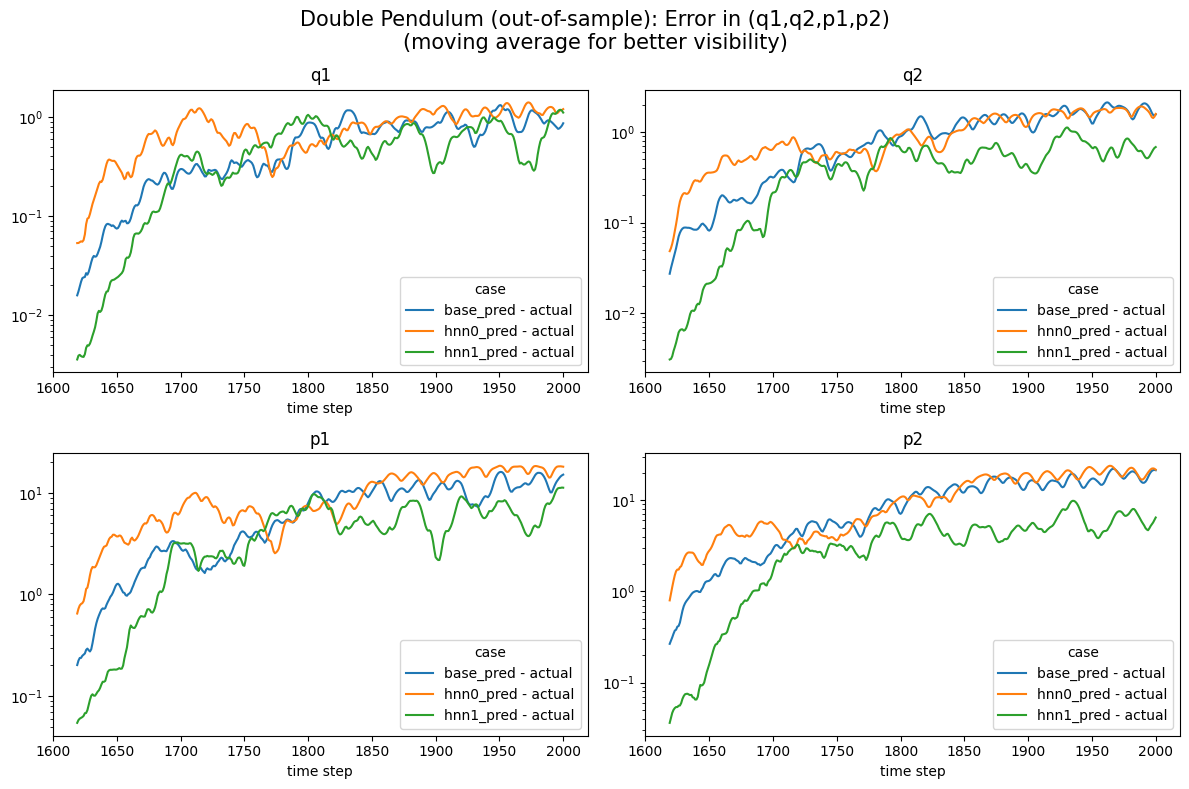

In [68]:
fig, axes = plt.subplots(int(len(X_vars) / 2), 2, figsize=(12, 2.0 * len(X_vars)))
for i, ax in enumerate(
    axes.reshape(
        len(X_vars),
    )
):
    val = X_vars[i]
    df_plot = df_err_qp[X_vars + ["case"]].pivot_table(
        index=df_err_qp.index, values=val, columns="case"
    )
    import numpy as np

    df_plot.rolling(20).mean().plot(ax=ax)
    ax.set_title(val)
    ax.set_xlabel("time step")
    ax.set_yscale("log")
fig.suptitle(
    "Double Pendulum (out-of-sample): Error in (q1,q2,p1,p2)\n(moving average for better visibility)",
    size=15,
)
fig.tight_layout()
fig.savefig("fig/hnn_double_pendulum_error_qp.png", dpi=200, facecolor="white")


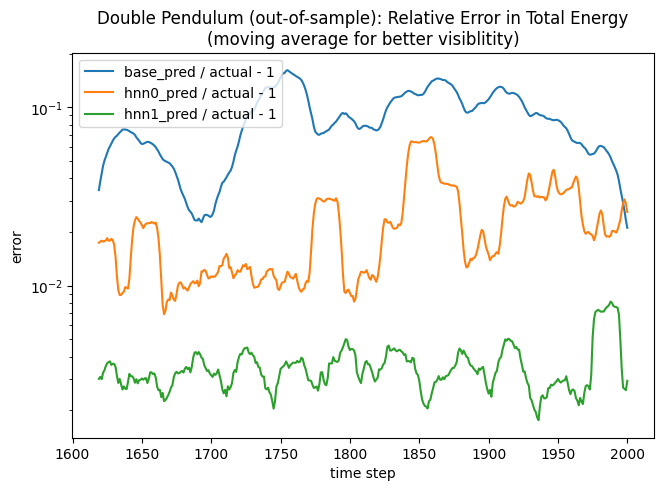

In [64]:
fig, ax = plt.subplots(figsize=(7.5, 2.5 * 2))
val = col_energy_total
df_plot = df_err_energy[[col_energy_total, "case"]].pivot_table(
    index=df_err_energy.index, values=val, columns="case"
)
df_plot.rolling(20).mean().plot(ax=ax)
ax.set_title(val)
ax.set_xlabel("time step")
ax.set_ylabel("error")
ax.set_yscale("log")
ax.set_title(
    "Double Pendulum (out-of-sample): Relative Error in Total Energy\n(moving average for better visiblitity)"
)
ax.legend(loc="upper left")
fig.savefig("fig/hnn_double_pendulum_error_energy.png", dpi=200, facecolor="white")
